# Isolation Forest

This notebook explores the `sklearn` Isolation Forest model and its methods by applying it to preprocessed TESS mission data. Preprocessing included imputing missing values via ARIMA forecasting and detrending with STL.

## Load Data

In [ ]:
## Libraries
# lightkurve
#import lightkurve as lk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
# from sklearn.preprocessing import StandardScaler

In [ ]:
## Data
df = pd.read_csv('../data/processed/031381302_imputed.csv', index_col = 0)
df.sort_index(inplace=True)
df.index.set_names('time', inplace=True)

# Check
print(df.shape)
print(df.head())

## Time Series of interest
lightcurve = df.loc[:, ['pdcsap_clean']]

# Check
print(lightcurve.shape); lightcurve.info(); lightcurve.head()

(18229, 4)
             pdcsap_flux  pdcsap_clean        trend   seasonal
time                                                          
1438.198088    1561.9932      5.311516  1563.355713  -6.674029
1438.199477    1530.5082     -3.632461  1563.361493 -29.220832
1438.200866    1534.7330     -0.707427  1563.367263 -27.926837
1438.202255    1558.9431     -2.543875  1563.373024  -1.886049
1438.203644    1553.7203     -1.282835  1563.378776  -8.375641
(18229, 1)
<class 'pandas.core.frame.DataFrame'>
Float64Index: 18229 entries, 1438.198088310551 to 1463.6229730857283
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   pdcsap_clean  18229 non-null  float64
dtypes: float64(1)
memory usage: 284.8 KB


,pdcsap_clean
time,
1438.198088,5.311516
1438.199477,-3.632461
1438.200866,-0.707427
1438.202255,-2.543875
1438.203644,-1.282835


## Model Setup

In [3]:
## Hyperparameters
n_estimators = 100 # Number of trees
contamination = 0.001 # Expected proportion of anomalies
sample_size = 256 # Number of samples used to train each tree

## Train Model

In [4]:
## Isolation Forest
model = IsolationForest(n_estimators = n_estimators, contamination = contamination, max_samples = sample_size)
#contamination = 'auto', random_state = 42)
# random_state: for reproducibility.
model.fit(lightcurve)

## Predict anomalies
anomalies = model.predict(lightcurve)
scores = model.decision_function(lightcurve)

## Save
lightcurve['anomaly'] = anomalies
lightcurve['anomaly'] = lightcurve['anomaly'].map({1: 0, -1: 1})
lightcurve['anomaly_score'] = scores

C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


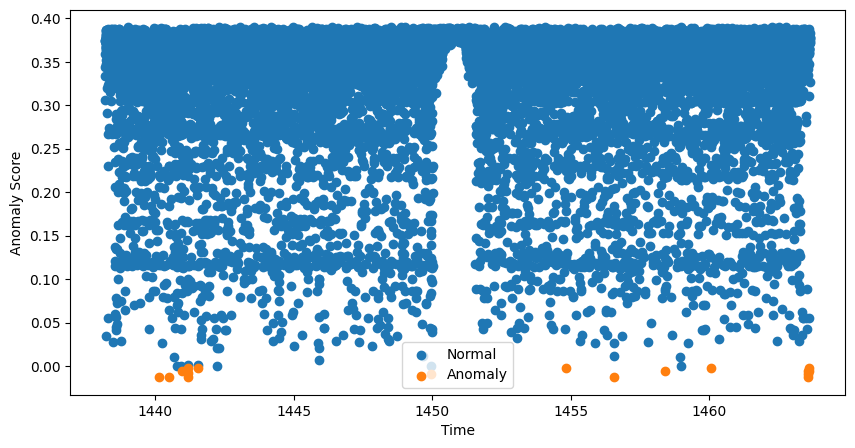

In [6]:
## Plot - Anomaly Scores
plt.figure(figsize=(10, 5))

# Plot normal instances
normal = lightcurve[lightcurve['anomaly'] == 0]
plt.scatter(normal.index, normal['anomaly_score'], label='Normal')

# Plot anomalies
anomalies = lightcurve[lightcurve['anomaly'] == 1]
plt.scatter(anomalies.index, anomalies['anomaly_score'], label='Anomaly')
plt.xlabel('Time')
plt.ylabel('Anomaly Score')
plt.legend()
plt.show()

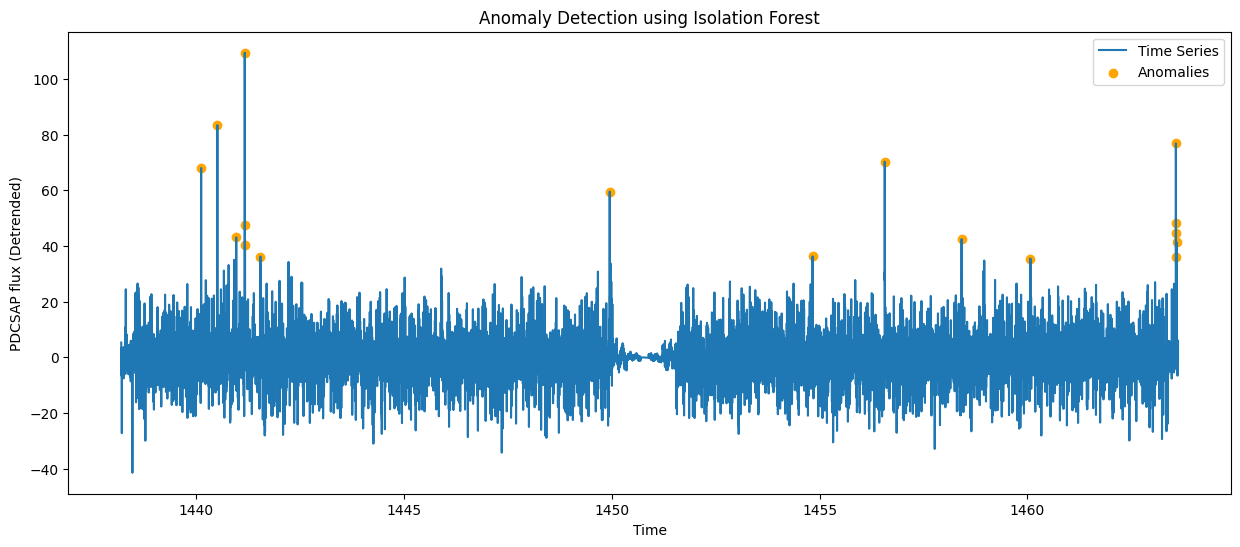

In [7]:
## Plot - Highlight anomalies
plt.figure(figsize=(15, 6))
plt.plot(lightcurve['pdcsap_clean'], label='Time Series')#, color='steelblue')
plt.scatter(anomalies.index, anomalies['pdcsap_clean'], label='Anomalies', color='orange')
plt.title('Anomaly Detection using Isolation Forest')
plt.xlabel('Time')
plt.ylabel('PDCSAP flux (Detrended)')
plt.legend()
plt.show()

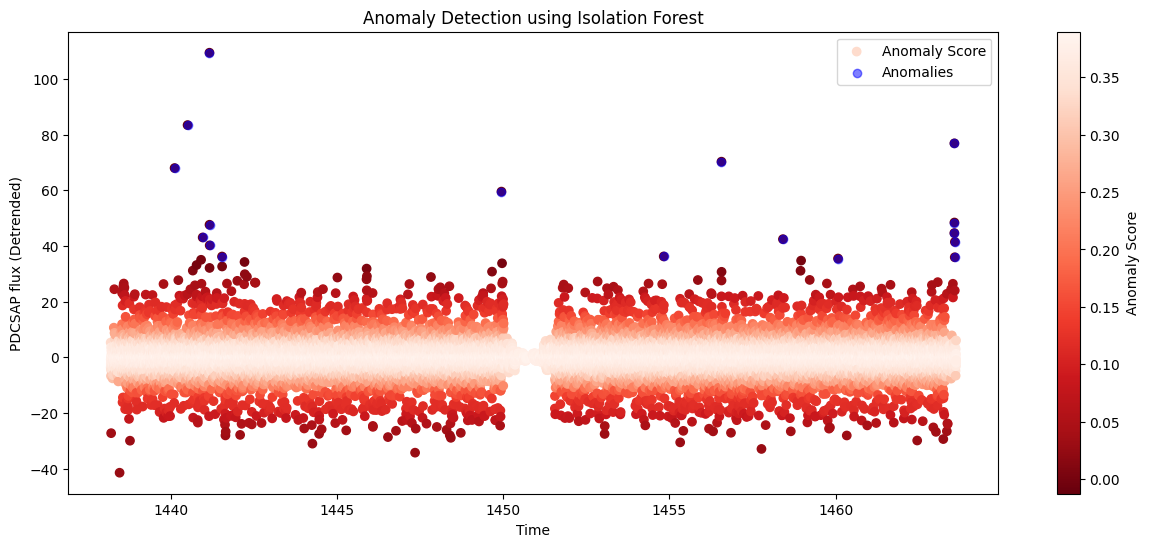

In [12]:
## Plot - Anomaly scores
plt.figure(figsize=(15, 6))
plt.scatter(lightcurve.index, lightcurve['pdcsap_clean'], c=lightcurve['anomaly_score'], cmap='Reds_r', label='Anomaly Score')
plt.colorbar().set_label('Anomaly Score')
plt.scatter(anomalies.index, anomalies['pdcsap_clean'], label='Anomalies', color='blue', alpha=0.5)
plt.title('Anomaly Detection using Isolation Forest')
plt.xlabel('Time')
plt.ylabel('PDCSAP flux (Detrended)')
plt.legend()
plt.show()

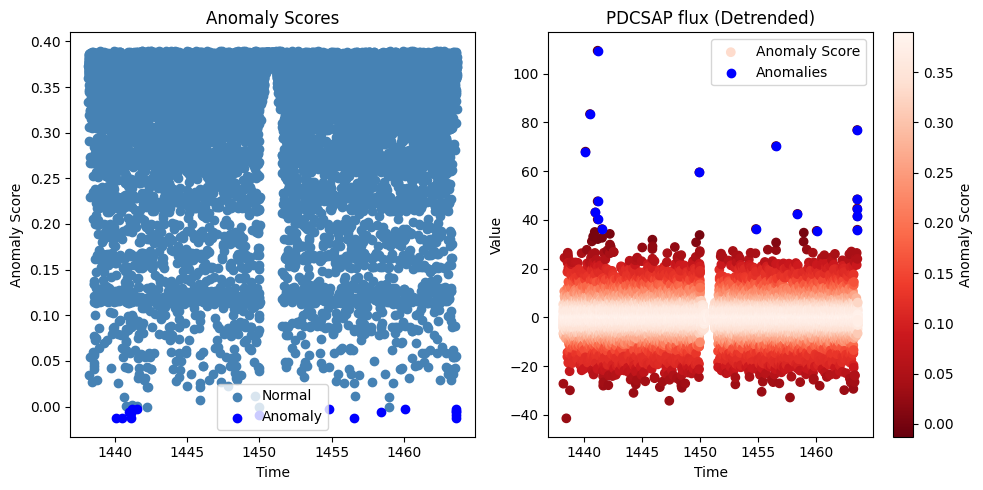

In [13]:
## Progress Report
# Anomaly Scores
fig, ax = plt.subplots(1, 2, figsize=(10, 5)) # 1 row, 2 columns

# Anomaly Scores vs. Time
# Plot normal instances
ax[0].scatter(normal.index, normal['anomaly_score'], label='Normal', color='steelblue')
# Plot anomalies
ax[0].scatter(anomalies.index, anomalies['anomaly_score'], label='Anomaly', color='blue')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Anomaly Score')
ax[0].set_title('Anomaly Scores')
ax[0].legend()

# Time Series coloured by Anomaly Scores
sc = ax[1].scatter(lightcurve.index, lightcurve['pdcsap_clean'], c=lightcurve['anomaly_score'], cmap='Reds_r', label='Anomaly Score')
# Colorbar
cbar = fig.colorbar(sc, ax=ax[1])
cbar.set_label('Anomaly Score')

ax[1].scatter(anomalies.index, anomalies['pdcsap_clean'], label='Anomalies', color='blue')#, alpha=0.5) #, marker='.')
ax[1].set_title('PDCSAP flux (Detrended)')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Value')
ax[1].legend()

# plot_acf(pdcsap["pdcsap_flux"], lags = 1000, ax = ax[0], auto_ylims = True, zero = False)
# plot_pacf(pdcsap["pdcsap_flux"], lags = 1000, ax = ax[1], method = "ywm", auto_ylims = True, zero = False)

plt.tight_layout()
plt.show()

# Anomaly Detection


## Exploration

Here, I began exploring mapping flares with the anomaly scores returned by the Isolation Forest model.

In [15]:
## Anomaly Score Percentile Intervals
# Ideas:
# - Make threshold scale with distance from nearest anomaly
def map_flare(ind, threshold = 0.9):
    ## If not anomaly, break.
    if lightcurve.loc[ind, 'anomaly'] == 0:
        return
    
    ## Setup
    flare = [ind]
    num_ind = np.where(lightcurve.index == ind)[0][0]
    cont, i = True, 1

    ## Iterate
    # while cont:
    #     ## Backward
    #     if lightcurve.iloc[num_ind] #[num_ind - i]
    #     ## Forward

    #     i += 1

    return flare

## Setup
anomaly_inds = np.where(lightcurve['anomaly'] == 1)[0]
    #lightcurve.iloc[np.where(lightcurve['anomaly'] == 1)[0]].index
print(anomaly_inds)

## Iterate
# for id in anomaly_inds:
#     map_flare(id)

# lightcurve['flare'] = lightcurve.loc[anomaly_inds].index.apply(map_flare, axis = 'index')

# Check
# print(lightcurve.iloc[0][0])
# bonk = lightcurve['anomaly'].apply(lambda x: x + 1)
# bonk.head()

[ 1369  1650  1942  1977  2106  2107  2111  2357  8387 11898 13148 14479
 15672 18190 18191 18192 18199 18202]


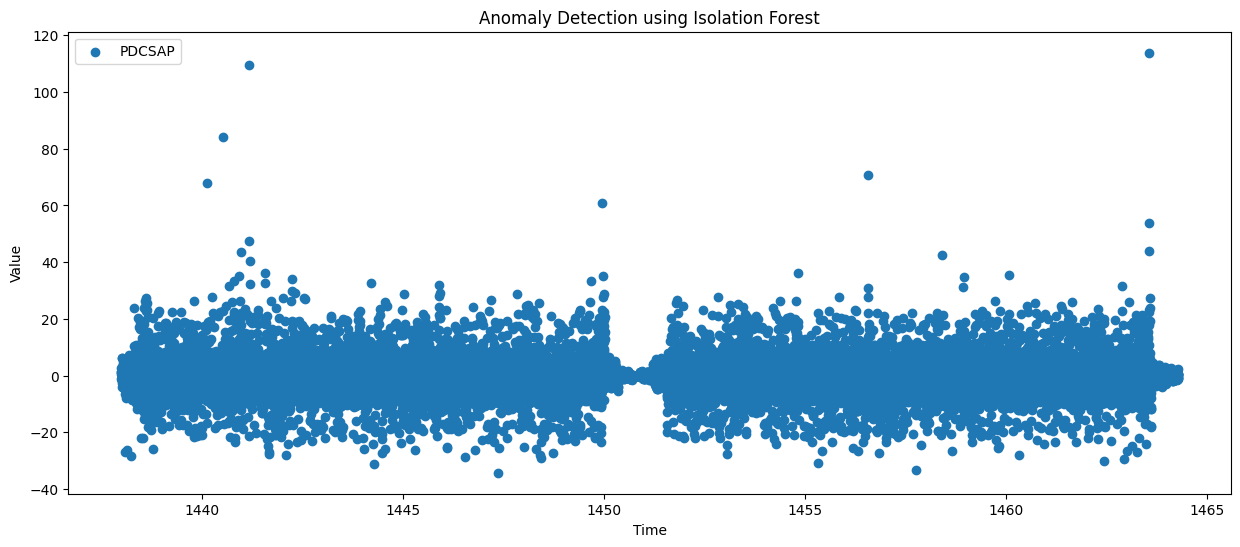

In [ ]:
## Plot
plt.figure(figsize=(15, 6))
plt.scatter(lightcurve.index, lightcurve['pdcsap_clean'], label = 'PDCSAP')
# plt.scatter(anomalies.index, anomalies['pdcsap_clean'], label='Anomalies', color = 'orange')
plt.title('Anomaly Detection using Isolation Forest')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()